# ARFS - classification

ARFS can be used for classification (binary or multi-class) and for regression. You just have to specify the right loss function.



In [19]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import catboost
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.feature_selection import MinRedundancyMaxRelevance, GrootCV, MissingValueThreshold, UniqueValuesThreshold, CollinearityThreshold, make_fs_summary
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [20]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 1.0.0


In [21]:
import importlib
importlib.reload(arfs)

<module 'arfs' from 'c:\\users\\xtbury\\documents\\projects\\github-tb\\allrelevantfs\\arfs\\__init__.py'>

In [22]:
%matplotlib inline

In [23]:
gc.enable()
gc.collect()

46738

## Simple Usage
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical) and a genuine but noisy artificial predictor (correlated to the target). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.


In [24]:
# titanic = load_data(name='Titanic')
# X, y = titanic.data, titanic.target

In [25]:
titanic = load_data(name='Titanic')
X, y = titanic.data, titanic.target
y = y.astype(int)

## Leshy

In [26]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMClassifier(random_state=42, verbose=-1)
# model = CatBoostClassifier(random_state=42, verbose=0)
# model = XGBClassifier(random_state=42, verbosity=0)

with native (impurity/Gini) importance

Leshy iteration:  90%|█████████ | 9/10 [00:00<00:00, 13.08it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	1
Rejected: 	9
All relevant predictors selected in 00:00:00.70
The selected features: []
The agnostic ranking: [ 4  7  6  9 10  8  3  5  2  3]
The naive ranking: ['fare', 'age', 'random_num', 'pclass', 'family_size', 'embarked', 'sex', 'title', 'random_cat', 'is_alone']


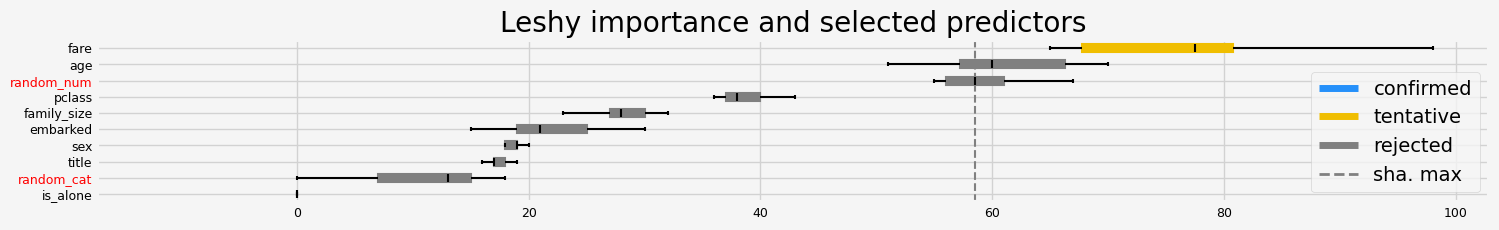

CPU times: total: 4.75 s
Wall time: 1.05 s


In [27]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance='native')
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

with SHAP importance

Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  5.97it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	0
Rejected: 	6
All relevant predictors selected in 00:00:01.52
The selected features: ['pclass' 'sex' 'embarked' 'fare']
The agnostic ranking: [1 1 1 6 7 2 3 5 1 3]
The naive ranking: ['sex', 'pclass', 'fare', 'embarked', 'title', 'age', 'random_num', 'family_size', 'random_cat', 'is_alone']


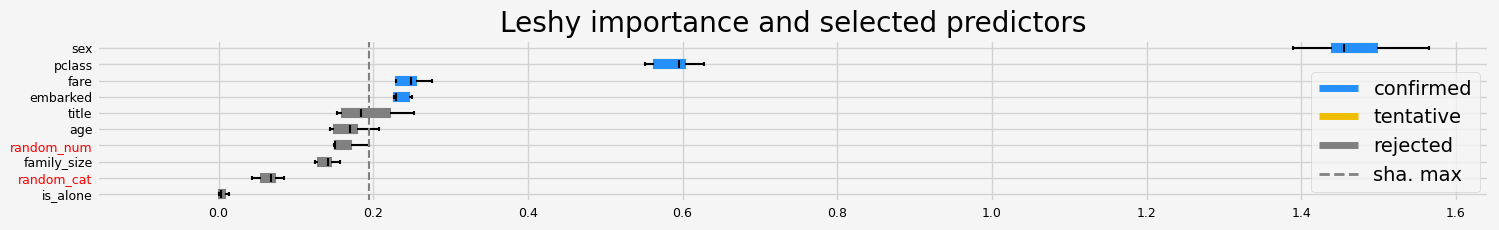

CPU times: total: 9.09 s
Wall time: 1.81 s


In [28]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

with permutation importance

Leshy iteration:  90%|█████████ | 9/10 [00:03<00:00,  2.89it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:03.13
The selected features: ['pclass' 'sex' 'title']
The agnostic ranking: [1 1 2 4 3 1 6 2 3 6]
The naive ranking: ['sex', 'pclass', 'title', 'family_size', 'embarked', 'fare', 'is_alone', 'random_cat', 'age', 'random_num']


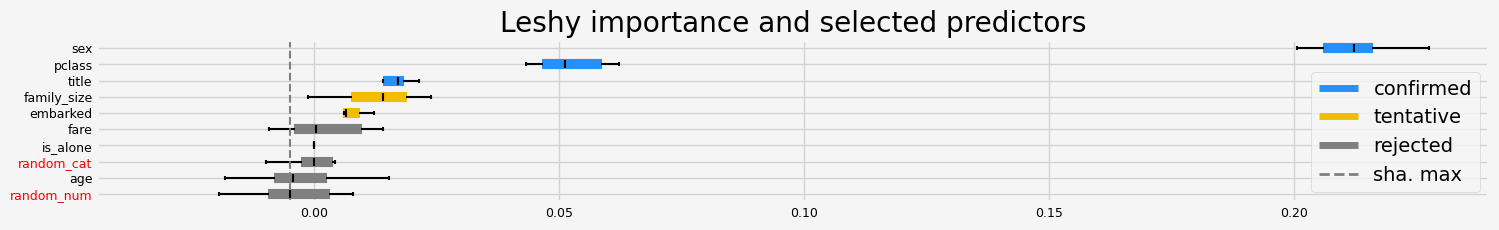

CPU times: total: 16.1 s
Wall time: 3.4 s


In [29]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance='pimp')
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## BoostAGroota

with permutation importance

BoostaGRoota round:  10%|█         | 1/10 [00:05<00:53,  5.90s/it]


The selected features: ['pclass' 'sex' 'age' 'family_size']
The agnostic ranking: [2 2 1 1 1 1 2 2 1 1]
The naive ranking: ['sex', 'pclass', 'age', 'family_size', 'fare', 'embarked', 'title', 'is_alone', 'random_cat', 'random_num']


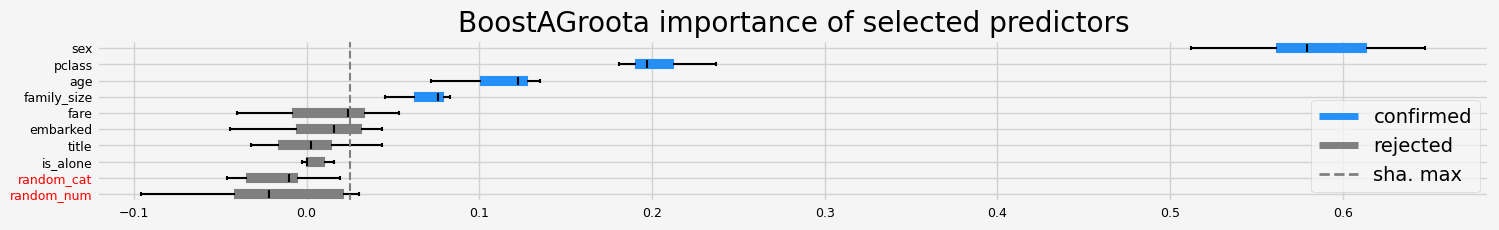

CPU times: total: 28.8 s
Wall time: 6.22 s


In [30]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='pimp')
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

with SHAP importance

BoostaGRoota round:  10%|█         | 1/10 [00:02<00:21,  2.41s/it]


The selected features: ['pclass' 'sex' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 1 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'family_size', 'random_num', 'title', 'random_cat', 'is_alone']


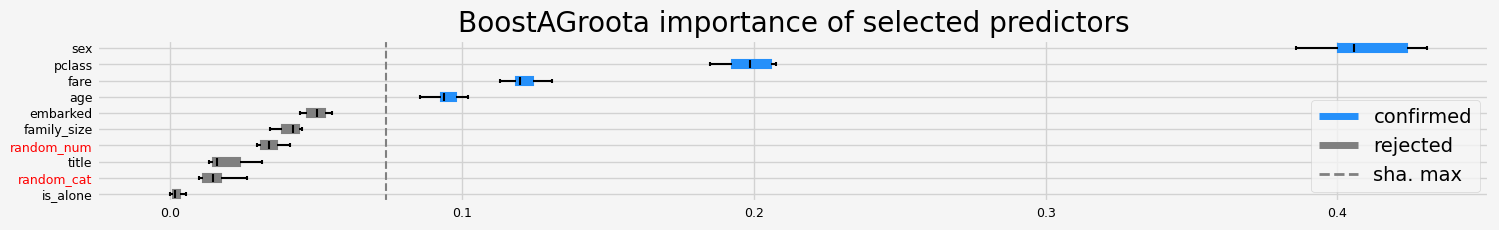

CPU times: total: 15.8 s
Wall time: 2.68 s


In [31]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## GrootCV

Internally, it uses lightGBM and SHAP importance (fast and accurate)

Repeated k-fold: 100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


The selected features: ['pclass' 'sex' 'title' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 2 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'title', 'embarked', 'family_size', 'random_num', 'random_cat', 'is_alone']


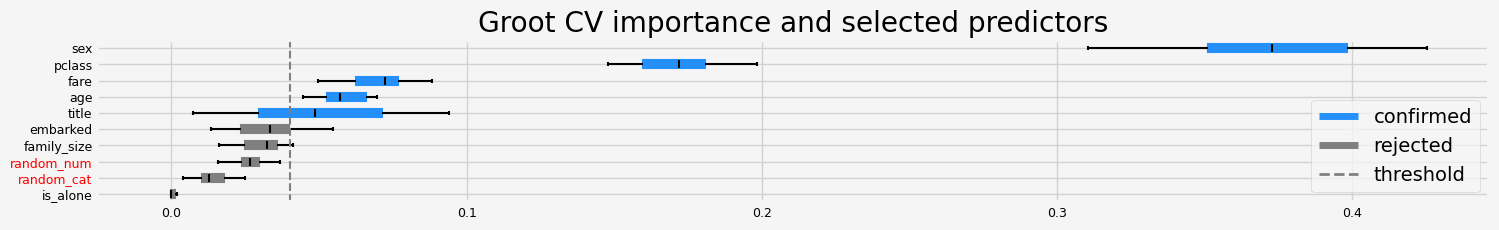

CPU times: total: 25.4 s
Wall time: 3.75 s


In [32]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='binary', cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## ARFS in sklearn pipelines

all the selectors (basic, arfs and MRmr) are sklearn compatible and follows the same architecture. Namely, they use the sklearn relevant base classes and therefore have the same methods.

In [45]:
model = clone(model)

# # Leshi/Boruta
# feat_selector = arfsgroot.Leshy(model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance='shap')

# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='shap')

# GrootCV
# feat_selector = arfsgroot.GrootCV(objective='binary', cutoff=1, n_folds=5, n_iter=5, silent=True)

arfs_fs_pipeline = Pipeline([
    ('missing', MissingValueThreshold(threshold=.05)),
    ('unique', UniqueValuesThreshold(threshold=1)),
    ('collinearity', CollinearityThreshold(threshold=0.85)),
    ('arfs', feat_selector),
])

X_trans = arfs_fs_pipeline.fit(X=X, y=y).transform(X=X) 

BoostaGRoota round:  20%|██        | 2/10 [00:04<00:16,  2.07s/it]


In [34]:
arfs_fs_pipeline.named_steps['collinearity'].get_feature_names_out()

array(['pclass', 'embarked', 'random_cat', 'is_alone', 'title', 'fare',
       'random_num'], dtype=object)

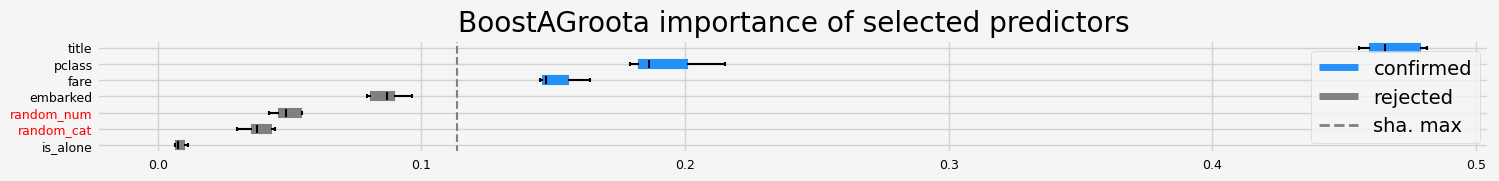

In [46]:
fig = arfs_fs_pipeline.named_steps['arfs'].plot_importance()
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## Testing and comparing Leshy, GrootCV and BoostAGroota

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.
For Leshy (Boruta) and BoostAGroota, the native feature importance (gini/impurity) returns the less reliable results.

==================== Benchmarking using sklearn permutation importance ====================


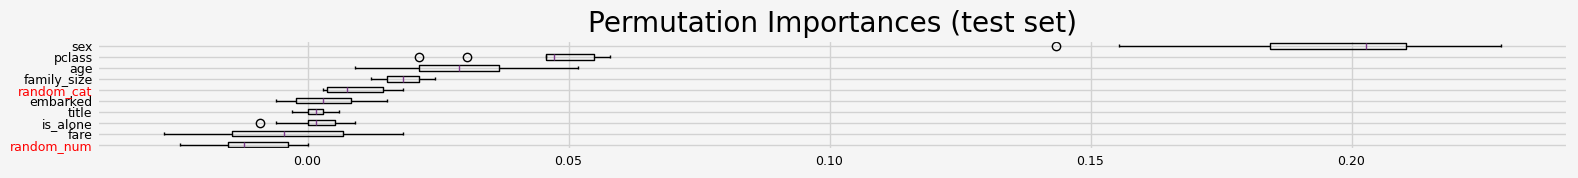

CPU times: total: 2.69 s
Wall time: 5.79 s


In [36]:
%%time

model = clone(model)
# Benchmark with scikit-learn permutation importance
print('=' * 20 + ' Benchmarking using sklearn permutation importance ' + '=' * 20)
fig = sklearn_pimp_bench(model, X, y, task='classification', sample_weight=None)

In [37]:
model.__class__.__name__

'LGBMClassifier'

### Testing Leshy

`use_label_encoder` is deprecated in 1.7.0.


==================== Leshy - testing:    RandomForestClassifier for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:23<00:02,  2.64s/it]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	6
Tentative: 	2
Rejected: 	2
All relevant predictors selected in 00:00:23.73
['pclass' 'sex' 'embarked' 'title' 'family_size' 'fare']


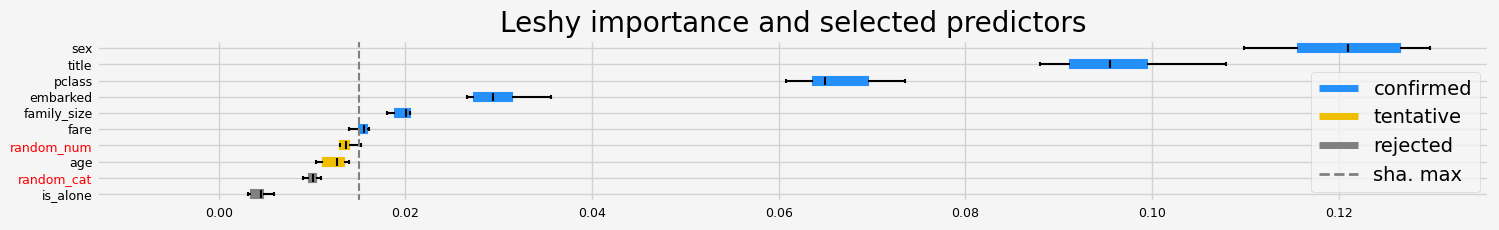

==================== Leshy - testing:    RandomForestClassifier for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:21<00:02,  2.34s/it]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	4
Rejected: 	3
All relevant predictors selected in 00:00:21.07
['pclass' 'sex' 'title']


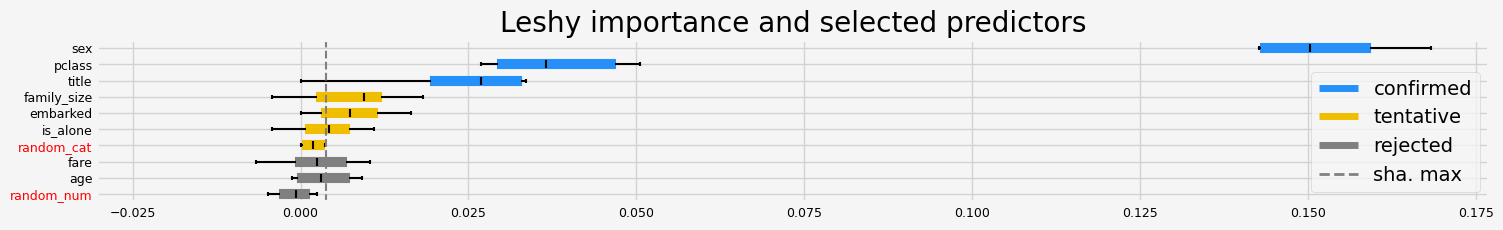

==================== Leshy - testing:    RandomForestClassifier for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:02<00:00,  3.36it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:02.69
['pclass' 'sex' 'title' 'fare' 'random_num']


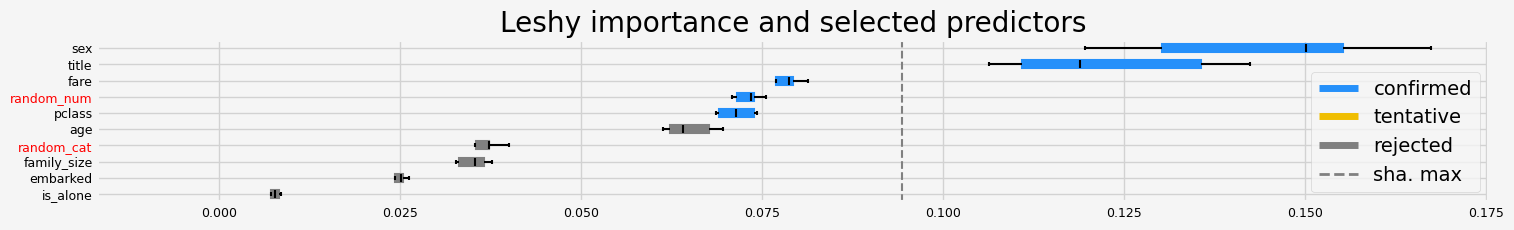

==================== Leshy - testing:        CatBoostClassifier for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:32<00:03,  3.66s/it]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	6
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:32.97
['pclass' 'sex' 'embarked' 'title' 'family_size' 'fare']


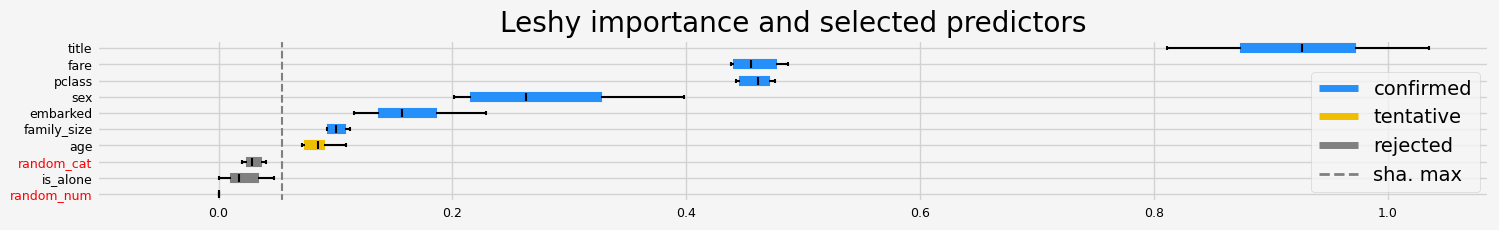

==================== Leshy - testing:        CatBoostClassifier for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:34<00:03,  3.87s/it]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:34.82
['pclass' 'title' 'fare']


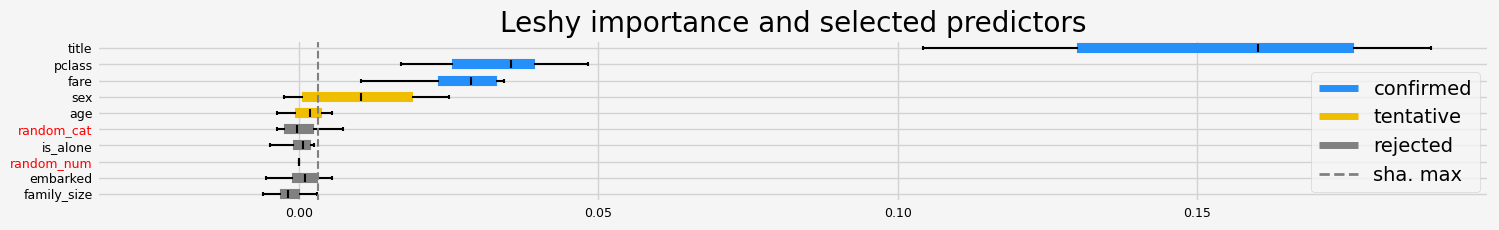

==================== Leshy - testing:        CatBoostClassifier for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:32<00:03,  3.64s/it]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:32.80
['pclass' 'sex' 'title' 'age' 'fare']


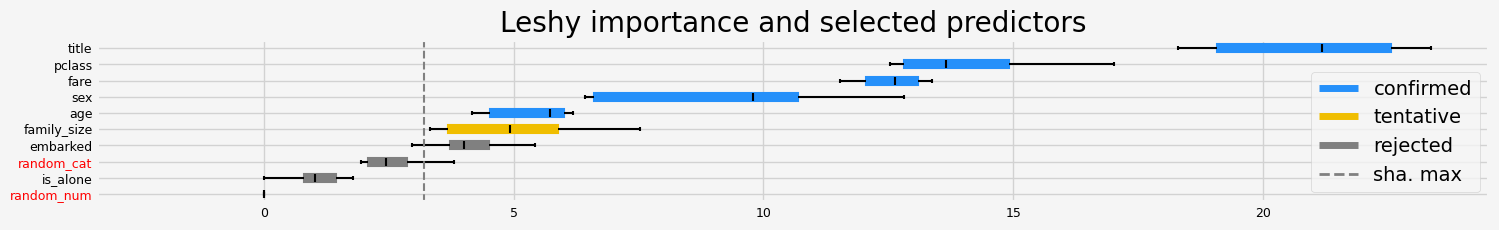

`use_label_encoder` is deprecated in 1.7.0.


==================== Leshy - testing:             XGBClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]`use_label_encoder` is deprecated in 1.7.0.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Leshy iteration:  10%|█         | 1/10 [00:00<00:03,  2.87it/s]`use_label_encoder` is deprecated in 1.7.0.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Leshy iteration:  20%|██        | 2/10 [00:00<00:02,  2.82it/s]`use_label_encoder` is deprecated in 1.7.0.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Leshy iteration:  30%|███       | 3/10 [00:01<00:02,  2.80it/s]`use_label_encoder` is deprecated in 1.7.0.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Leshy iteration:  40%|████      | 4/10 [00:01<00:02,  2.81it/s]`use_label_encoder` is deprecated in 1.7.0.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Leshy iteration:  50%|█████     | 5/10 [00:01<00:01,  2.80it/s]`use_label_encoder` is deprecated i



Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:03.21
['pclass' 'sex' 'fare']


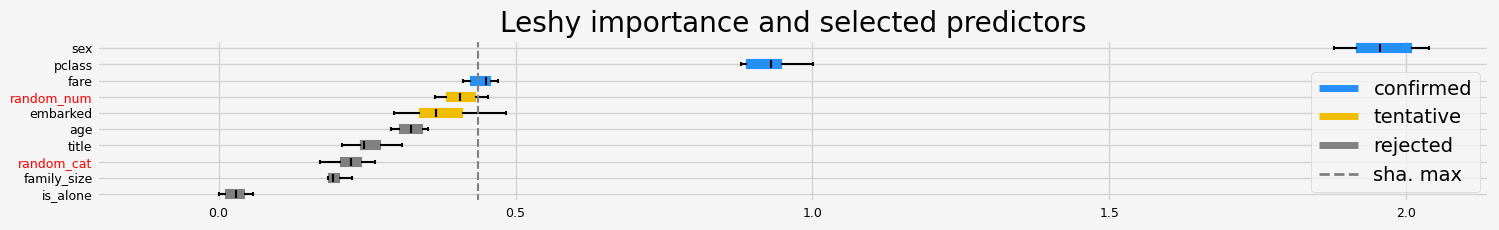

`use_label_encoder` is deprecated in 1.7.0.


==================== Leshy - testing:             XGBClassifier for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:03<00:00,  2.25it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	5
All relevant predictors selected in 00:00:04.01
['pclass' 'sex']


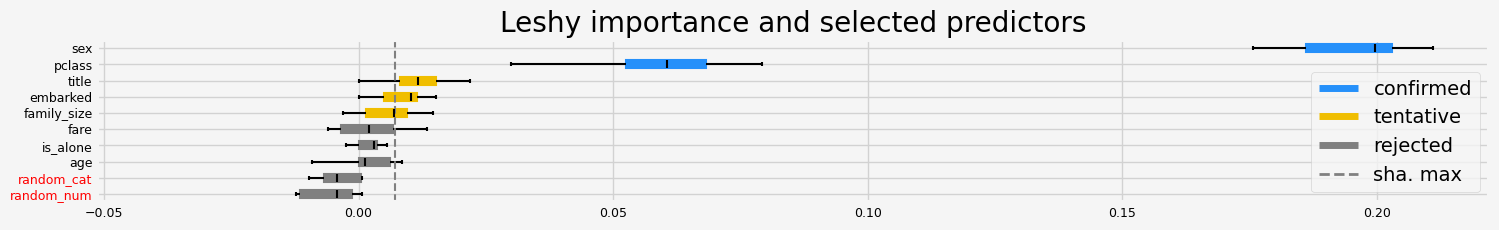

`use_label_encoder` is deprecated in 1.7.0.


==================== Leshy - testing:             XGBClassifier for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  5.17it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:01.76
['pclass' 'sex' 'title' 'family_size']


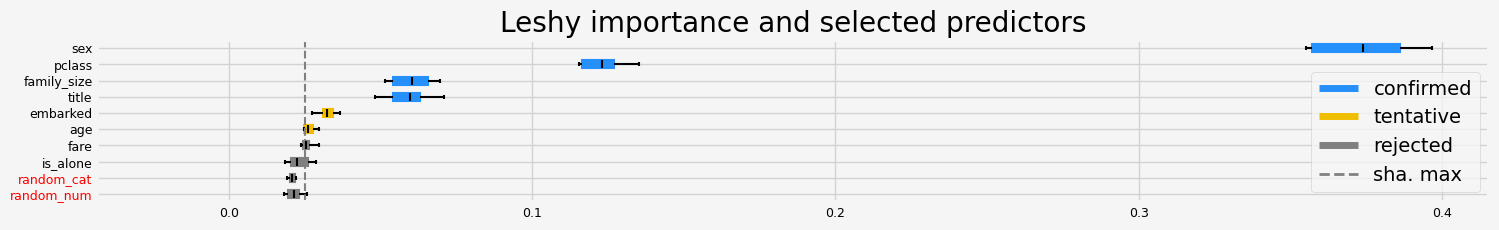

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  4.94it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	2
Rejected: 	6
All relevant predictors selected in 00:00:01.83
['pclass' 'sex']


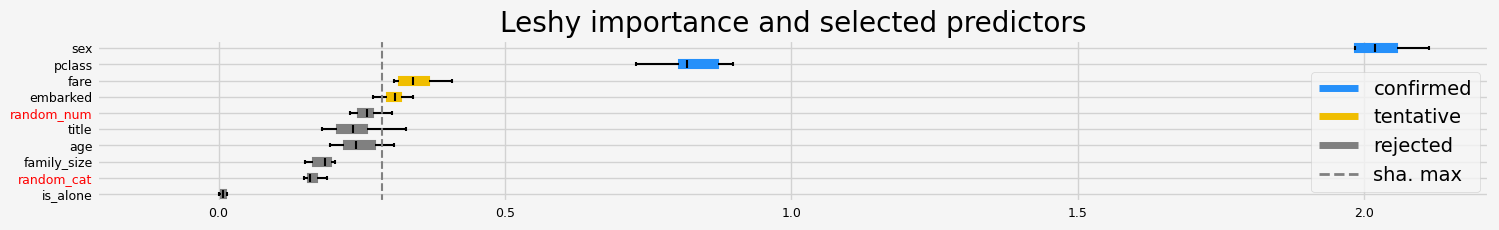

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:04<00:00,  2.04it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:04.43
['pclass' 'sex' 'title']


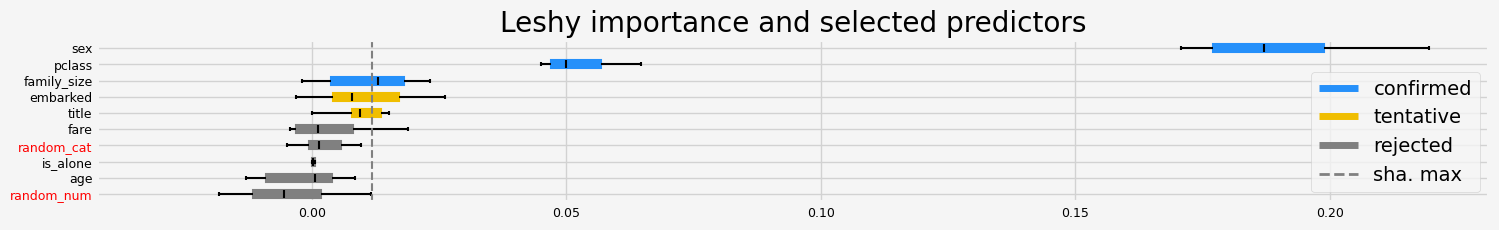

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  7.18it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:01.27
[]


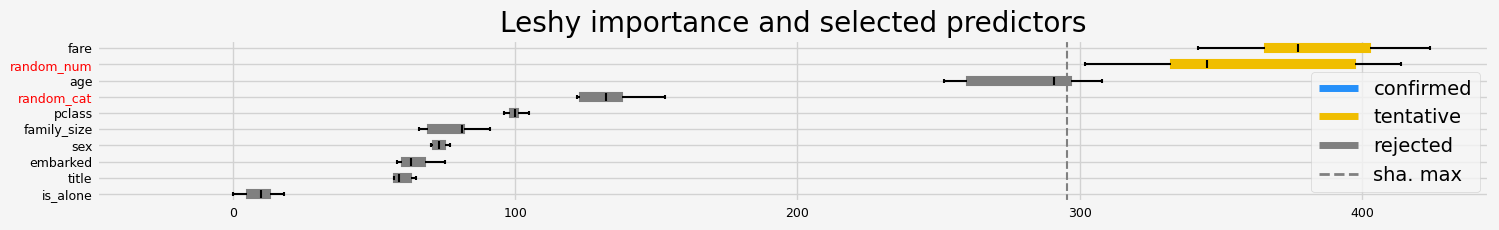

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  6.77it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	4
Rejected: 	3
All relevant predictors selected in 00:00:01.34
['pclass' 'sex' 'title']


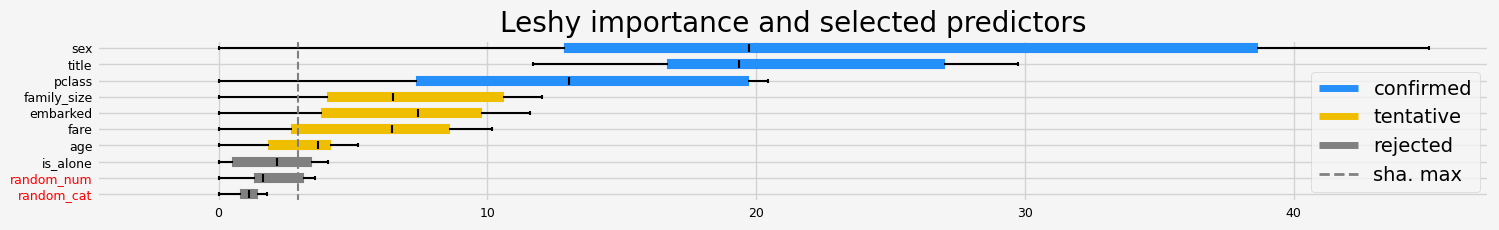

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:  90%|█████████ | 9/10 [00:03<00:00,  2.60it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	4
All relevant predictors selected in 00:00:03.47
['pclass' 'sex' 'title']


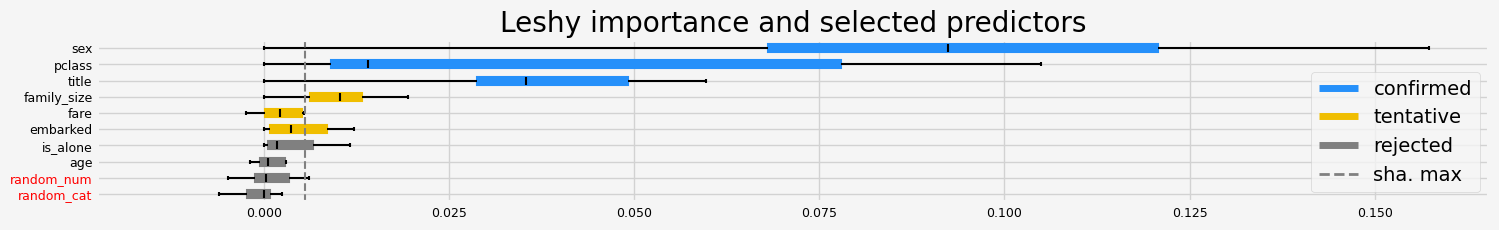

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:  90%|█████████ | 9/10 [00:01<00:00,  7.40it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:01.23
[]


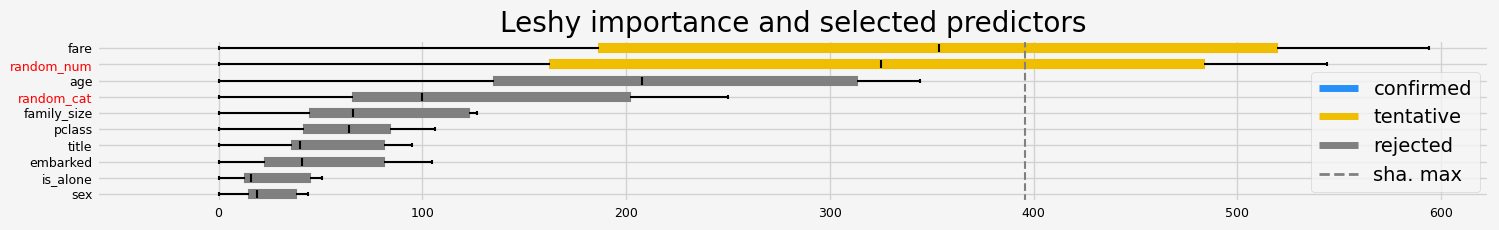

In [38]:
models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
          CatBoostClassifier(random_state=42, verbose=0), 
          XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False), 
          LGBMClassifier(random_state=42, verbose=-1),
          LightForestClassifier(n_feat=X.shape[1])]

feat_selector = arfsgroot.Leshy(model, n_estimators=100, verbose=1, max_iter=10, random_state=42)

if __name__ == '__main__':
    # classification
    titanic = load_data(name='Titanic')
    X, y = titanic.data, titanic.target.cat.codes
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

### Testing GrootCV

Repeated k-fold: 100%|██████████| 25/25 [00:03<00:00,  7.79it/s]


['pclass' 'sex' 'title' 'age' 'fare']


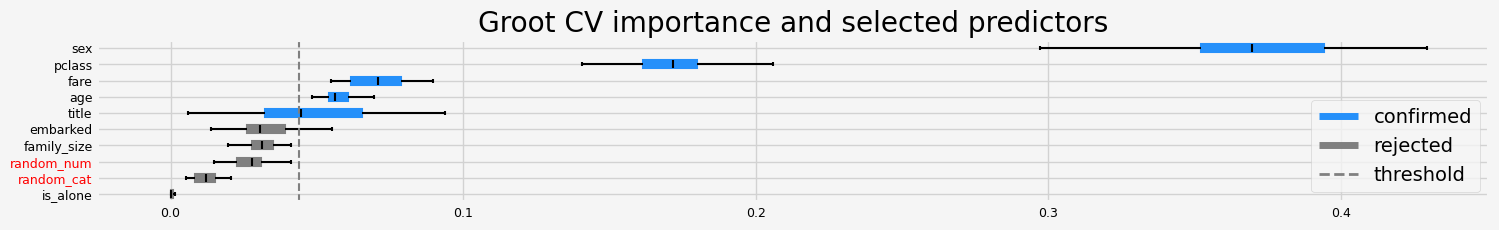

In [39]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective='binary'):
    feat_selector = arfsgroot.GrootCV(objective=objective, cutoff = 1, n_folds=5, n_iter=5)
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.get_feature_names_out())
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match='random')
    plt.show()
    gc.enable()
    del(feat_selector)
    gc.collect()
        

if __name__ == '__main__':
    # classification
    titanic = load_data(name='Titanic')
    X, y = titanic.data, titanic.target
    cat_f = titanic.categorical
    testing_estimators(X=X, y=y, objective='binary')

This confirms that the native (gini/gain) feature importance are biased and not the best to assess the real feature importance.

### Testing BoostAGroota

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: shap            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:03<00:12,  1.58s/it]


['age' 'fare' 'pclass' 'sex' 'embarked']


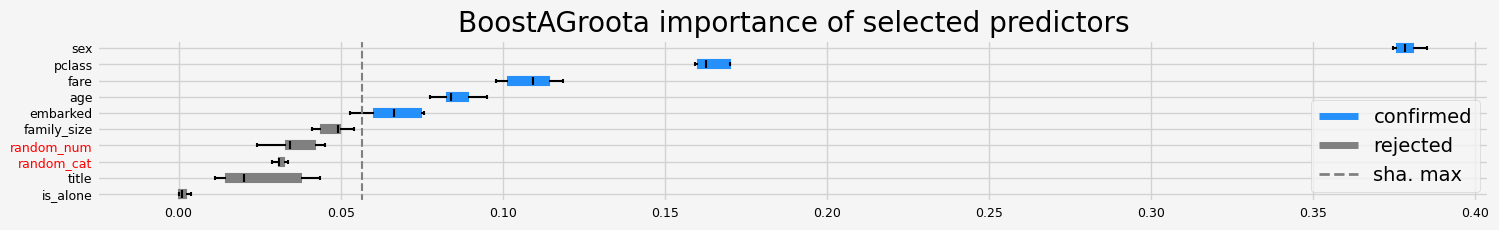

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:05<00:48,  5.35s/it]


['age' 'family_size' 'fare' 'pclass' 'sex']


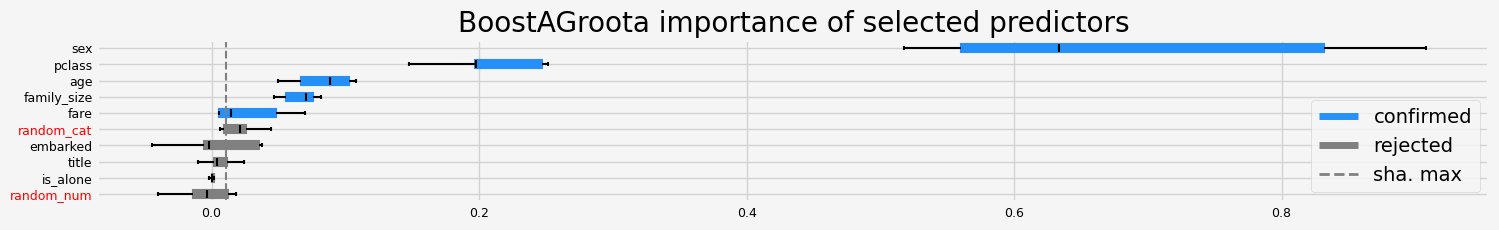

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:01<00:11,  1.29s/it]


['age' 'fare' 'random_num']


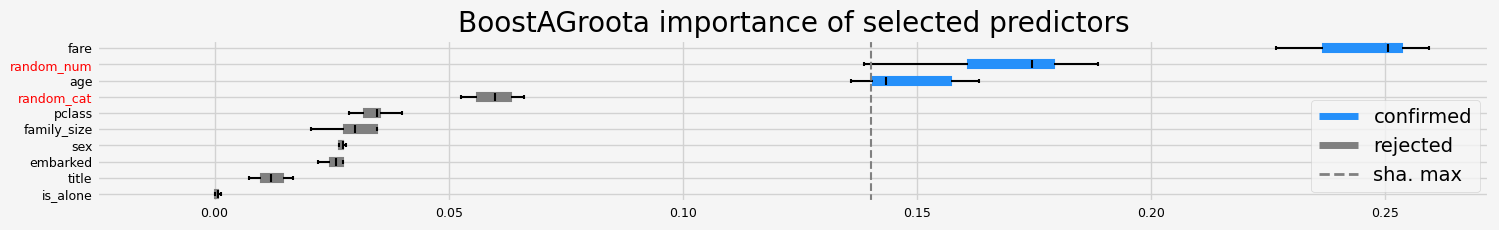

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: shap            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:02<00:11,  1.44s/it]


['age' 'fare' 'pclass' 'sex']


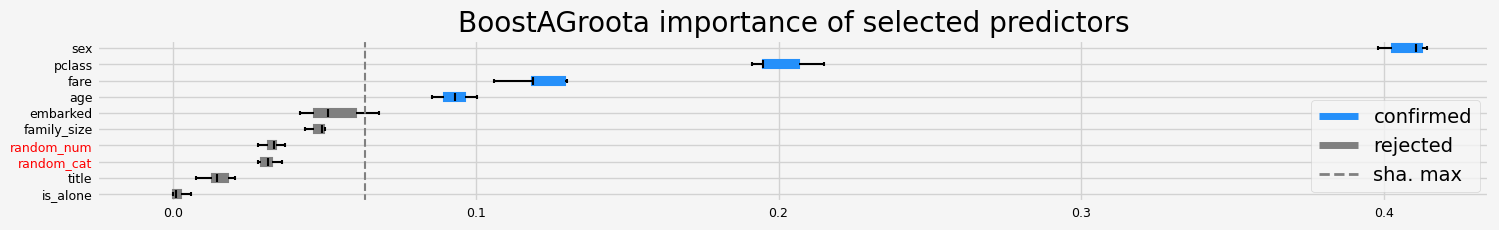

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: pimp            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:07<00:30,  3.82s/it]


['age' 'family_size' 'fare' 'pclass' 'sex']


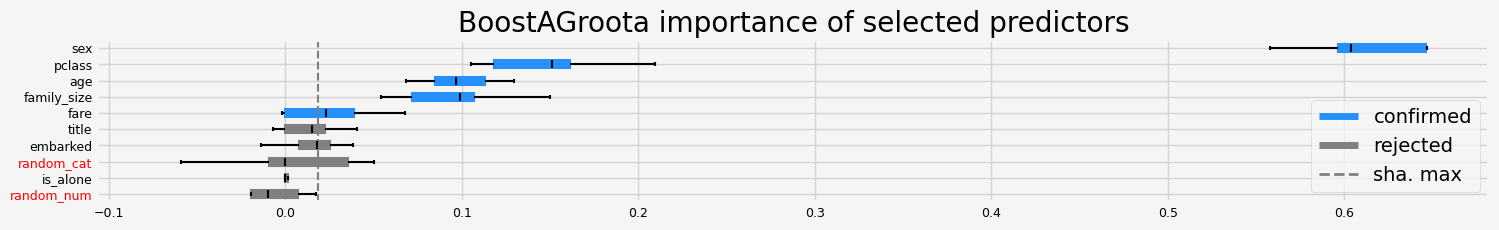

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:01<00:11,  1.32s/it]


['age' 'fare' 'random_num']


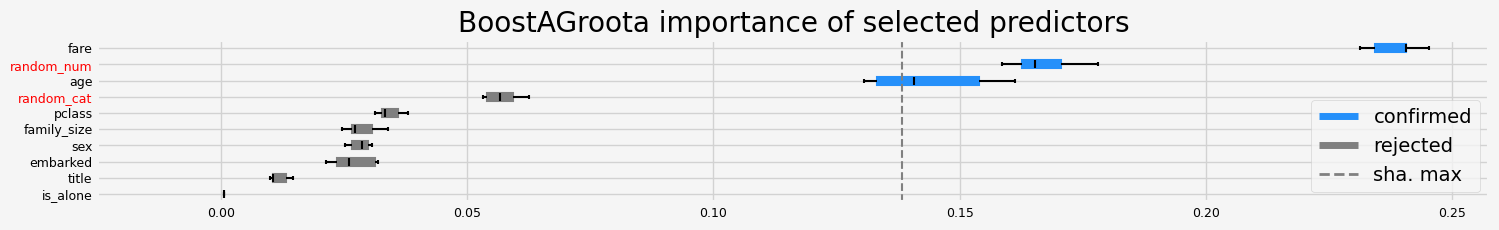

==================== BoostAGroota - testing:             XGBClassifier for var.imp: shap            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:03<00:12,  1.53s/it]


['age' 'fare' 'pclass' 'sex' 'embarked']


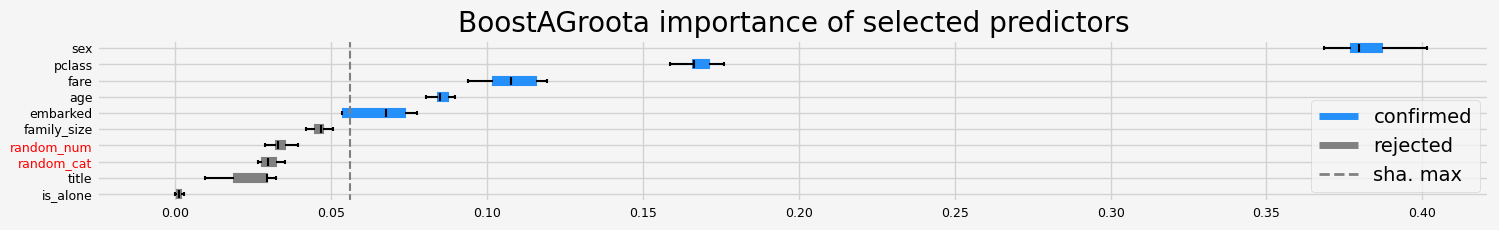

==================== BoostAGroota - testing:             XGBClassifier for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:05<00:47,  5.29s/it]


['age' 'family_size' 'fare' 'pclass' 'sex']


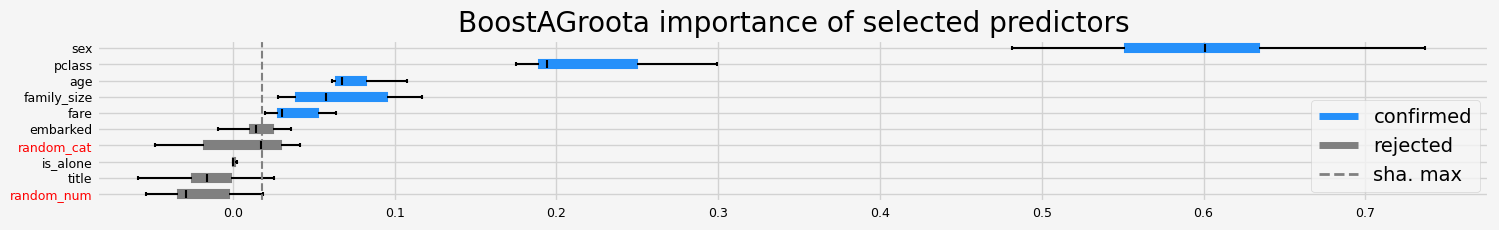

==================== BoostAGroota - testing:             XGBClassifier for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:01<00:11,  1.28s/it]


['fare' 'random_num']


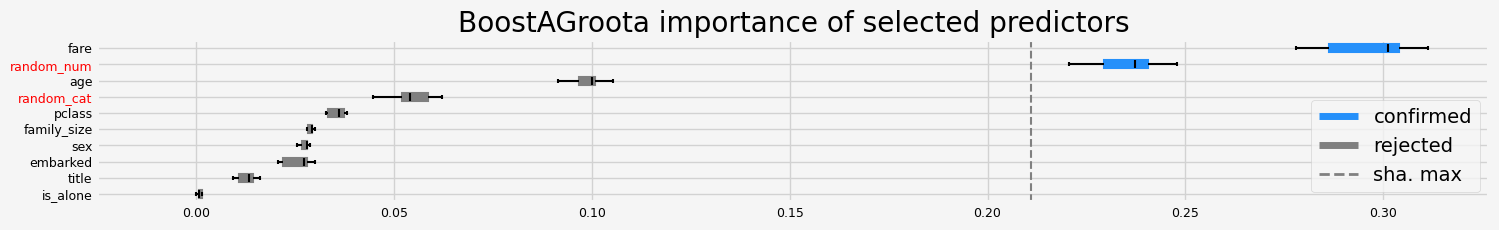

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: shap            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:03<00:12,  1.50s/it]


['age' 'fare' 'pclass' 'sex' 'embarked']


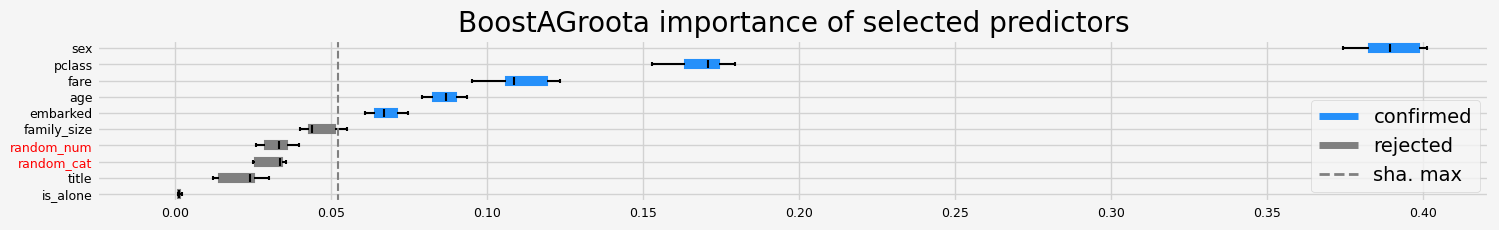

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: pimp            ====================


BoostaGRoota round:  10%|█         | 1/10 [00:05<00:49,  5.45s/it]


['age' 'family_size' 'fare' 'pclass' 'sex']


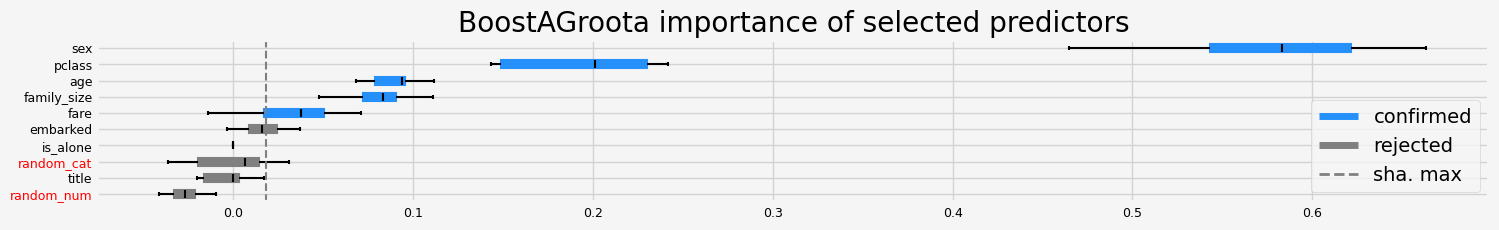

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:01<00:11,  1.29s/it]


['age' 'fare' 'random_num']


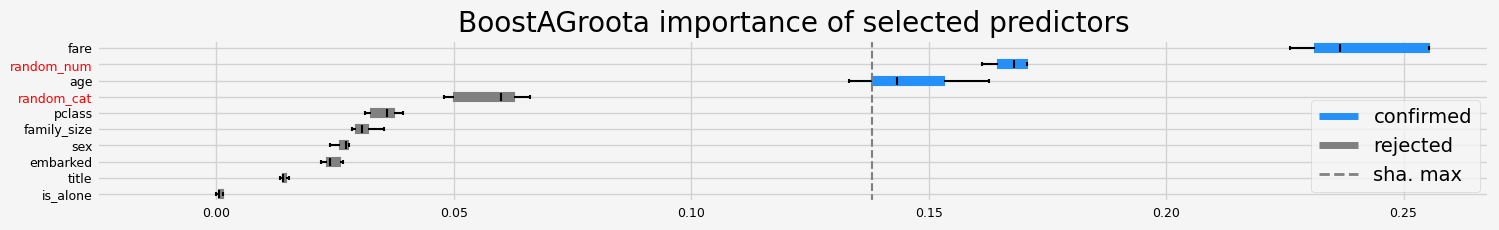

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: shap            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:03<00:12,  1.50s/it]


['age' 'fare' 'pclass' 'sex' 'embarked']


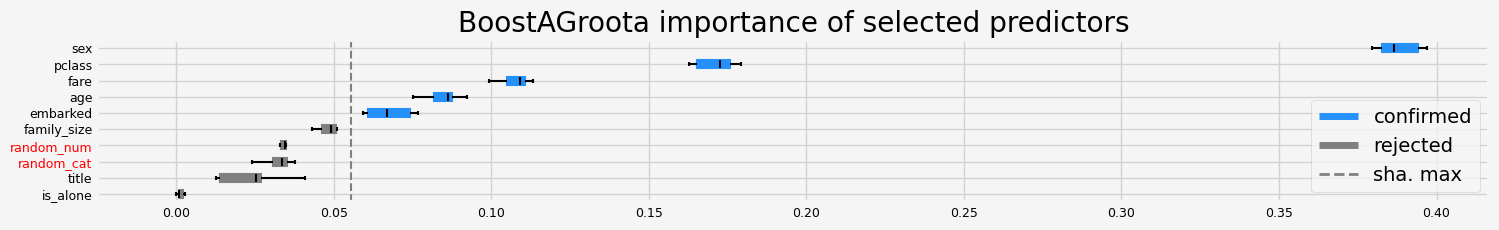

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: pimp            ====================


BoostaGRoota round:  20%|██        | 2/10 [00:07<00:31,  3.88s/it]


['age' 'family_size' 'fare' 'pclass' 'sex']


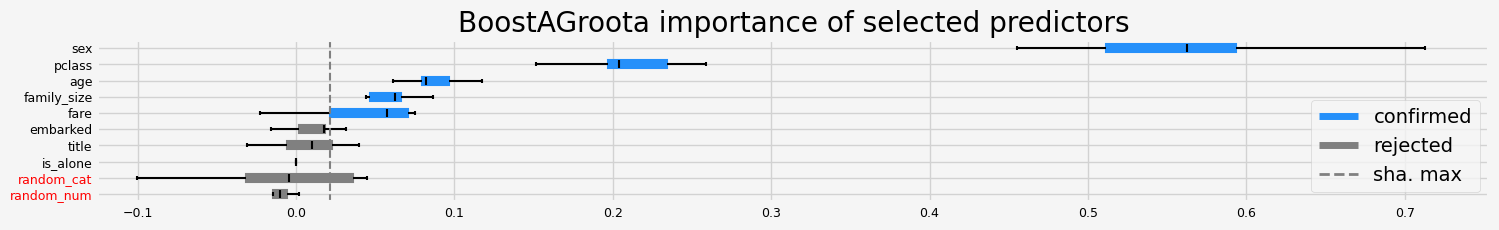

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: native          ====================


BoostaGRoota round:  10%|█         | 1/10 [00:01<00:11,  1.29s/it]


['age' 'fare' 'random_num']


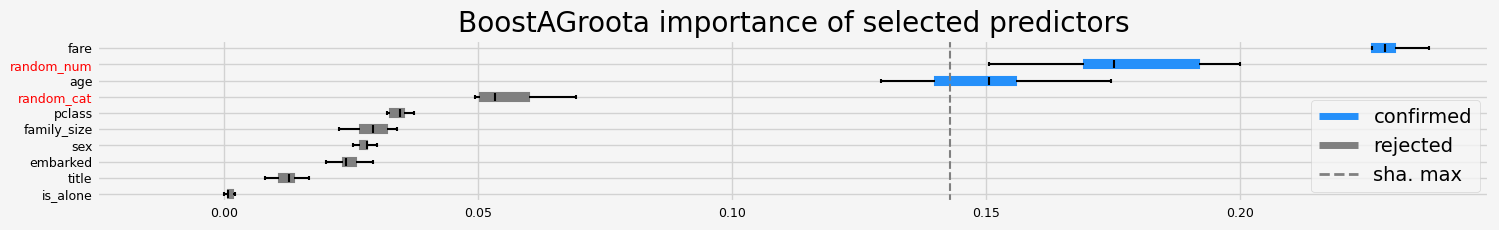

In [40]:
models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
          CatBoostClassifier(random_state=42, verbose=0), 
          XGBClassifier(random_state=42, verbosity=0), 
          LGBMClassifier(random_state=42, verbose=-1),
          LightForestClassifier(n_feat=X.shape[1])]

feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1.25, iters=10, max_rounds=10, delta=0.1)

if __name__ == '__main__':
    # classification
    titanic = load_data(name='Titanic')
    X, y = titanic.data, titanic.target
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

### comparing to BorutaShap

  0%|          | 0/100 [00:00<?, ?it/s]

5 attributes confirmed important: ['age', 'pclass', 'fare', 'sex', 'title']
5 attributes confirmed unimportant: ['embarked', 'family_size', 'random_num', 'random_cat', 'is_alone']
0 tentative attributes remains: []


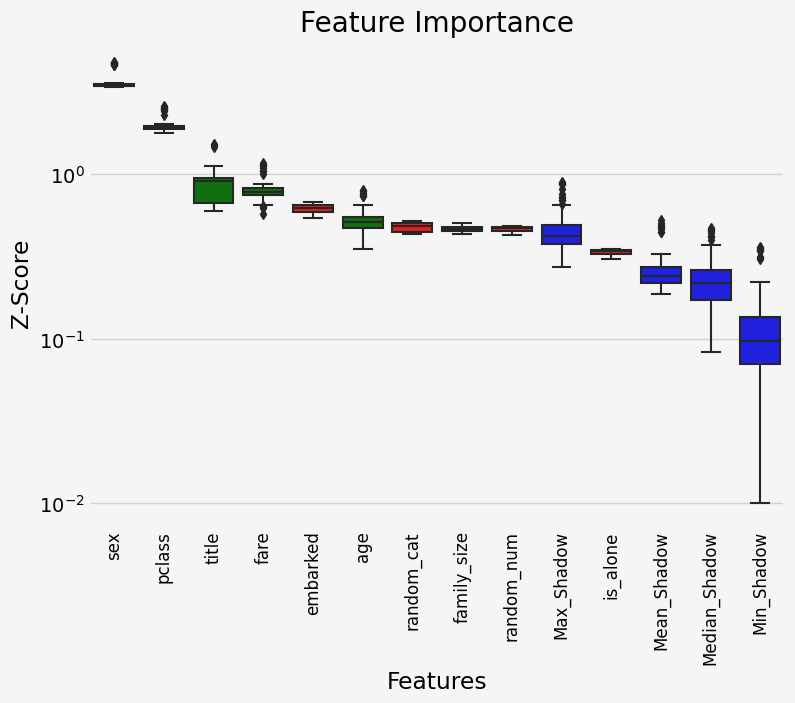

In [41]:
from BorutaShap import BorutaShap
from arfs.preprocessing import OrdinalEncoderPandas

model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=10)
X_encoded = OrdinalEncoderPandas().fit_transform(X=X)
Feature_Selector = BorutaShap(model=model, importance_measure='shap', classification=True)

Feature_Selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(8,6), y_scale='log', which_features='all')

Leshy iteration:  99%|█████████▉| 99/100 [00:03<00:00, 30.40it/s]




Leshy finished running using shap var. imp.

Iteration: 	100 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:03.29
['pclass' 'sex' 'embarked' 'random_cat' 'age' 'fare']


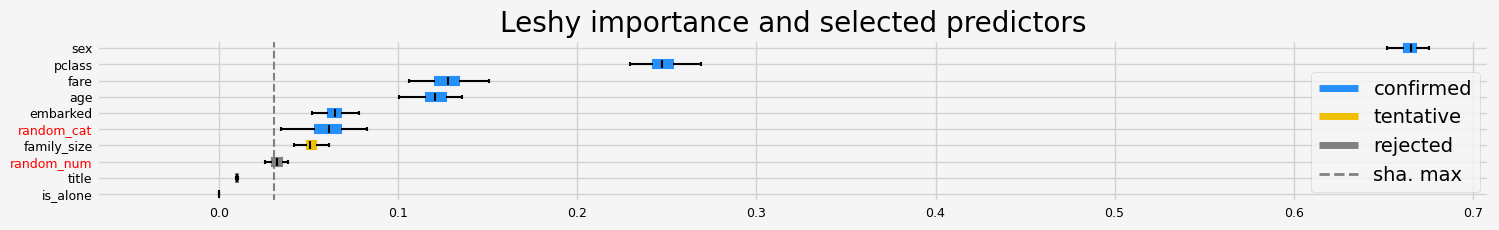

In [42]:
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators=10, verbose=1, max_iter=100, random_state=42, importance='shap')
feat_selector.fit(X_encoded, y, sample_weight=None)
print(feat_selector.get_feature_names_out())
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()